# Strava Stats Analysis

## Notebook & API Setup

In [18]:
# import packages
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import pandas as pd
from datetime import timedelta
pd.set_option("display.max.columns", None)
import requests
import json
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import matplotlib.pyplot as plt # import the scripting layer
import seaborn as sns
#import folium
#import polyline

# refresh access token (expires every 6 hours)
auth_url = "https://www.strava.com/oauth/token"
activities_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': "116573",
    'client_secret': 'f178359239fbb2c061697c8163a874471ca263de',
    'refresh_token': 'c00d945cd19b4238d9bdb9a5ebfcc1cff48ec05a',
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
header = {'Authorization': 'Bearer ' + access_token}
print("Access Token = {}\n".format(access_token))

Requesting Token...

Access Token = 1fc8422d119083b1c575916dfb2ac373b25ec41b



# API Data => .json

Strava has an api rate limit of 100 requests per 15 min and 1000 requests per day.

In [19]:
# define functions

# filters to only cycling activities with power and/or heart rate data
def filter_to_cycling_with_data(df):
    ride_df = df[(df['type'].isin(['Ride', 'VirtualRide']))].copy()

    # convert 'device watts' and 'has_heartrate' columns to boolean
    ride_df['device_watts'] = pd.to_numeric(ride_df['device_watts'], errors='coerce')
    ride_df['device_watts'].fillna(False, inplace=True)
    ride_df['has_heartrate'] = pd.to_numeric(ride_df['has_heartrate'], errors='coerce')
    ride_df['has_heartrate'].fillna(False, inplace=True)
    ride_df['device_watts'] = ride_df['device_watts'].astype(bool)
    ride_df['has_heartrate'] = ride_df['has_heartrate'].astype(bool)
    
    # filter to only cycling activities with power data or hr data
    ride_df = ride_df[ride_df['device_watts'] | ride_df['has_heartrate']]
    return ride_df

# retrieves general data for each ride on strava, only appends new rides
def get_new_rides():
    request_page_num = 1
    activities_byPage = []
    
    print('retrieving activity data...')
    while True:
        # fetches data from api; limited to 200 activities per request -- must retrieve by page
        param = {'per_page': 200, 'page': request_page_num}
        page_data = []
        page_data = requests.get(activities_url, headers=header, params=param).json()

        # break loop if page has no activities
        if len(page_data) == 0:
            print("retrieved all activities :)")
            break
        try:
            # break loop if exceeeded api rate limit 
            if page_data.get('message', '') == 'Rate Limit Exceeded':
                print('rate limit exceeded :(')
                break
        except AttributeError: # this is in an except because page_data won't have a 'message' if the rate limit has not been hit
            # build list of activities from pages
            print('retrieved ' + str(len(page_data)) + ' activities from page ' + str(request_page_num))
            activities_byPage.append(page_data)

            request_page_num += 1
    try:
        if (page_data.get('message', '') == 'Rate Limit Exceeded') & (len(activities_byPage) == 0):
            print('exiting...')
    except:
        # un-nests activities from pages, converts list to df, filters to rides with power
        all_activities = [item for sublist in activities_byPage for item in sublist]
        all_activities_df = pd.DataFrame(all_activities)
        all_rides_df = filter_to_cycling_with_data(all_activities_df)

        # appends only new activities so as not to overwrite existing data
        try:
            existing_rides_df = pd.read_json('strava_data.json', orient='records')
            new_ride_ids = list(set(all_rides_df['id'].values) - set(existing_rides_df['id'].values))
            new_rides_df = all_rides_df[all_rides_df['id'].isin(new_ride_ids)]
            ride_df = pd.concat([new_rides_df, existing_rides_df])
            ride_df.to_json('strava_data.json', orient='records')
            print(str(len(new_rides_df)) + ' new rides appended \n')
        except FileNotFoundError:
            ride_df = all_rides_df.copy()
            ride_df.to_json('strava_data.json', orient='records')
            print('error reading file - new file created')
            print(str(len(all_activities_df)) + ' new rides appended \n')

# gets details for power, heart rate, cadence and time data for each ride
def get_new_stream_data():
    ride_df = pd.read_json('strava_data.json', orient='records')
    metrics = ['watts', 'cadence', 'heartrate', 'time']
    for metric in metrics:
        if f'{metric}Stream' not in ride_df.columns:
            ride_df[f'{metric}Stream'] = None
            print(f'added {metric}Stream column')

    count = 0
    stream_data = []
    print('retrieving stream data...')
    for index, row in ride_df.iterrows():
        for metric in metrics:
            if ride_df.at[index, f'{metric}Stream'] == None: # only fill empty cells
                # define parameters for request
                stream_params = {'keys': {metric}, 'key_by_type': 'true'}

                # request stream data
                stream_url = f"https://www.strava.com/api/v3/activities/{row['id']}/streams"
                stream_data = requests.get(stream_url, headers=header, params=stream_params).json()
                
                if stream_data == []:
                    print('empty list, skipping')
                    ride_df.at[index, f'{metric}Stream'] = 'n/a'
                    continue

                if stream_data.get('message') == 'Rate Limit Exceeded':
                    print('rate limit exceeded :(')
                    break

                # assign power data to the appropriate ride in the DataFrame
                try:
                    ride_df.at[index, f'{metric}Stream'] = stream_data[f'{metric}']['data']
                    count += 1
                except KeyError:
                    ride_df.at[index, f'{metric}Stream'] = 'n/a'
            else:
                # skip cells with data
                continue
        if stream_data == []:
            continue
        elif stream_data.get('message') == 'Rate Limit Exceeded':
            print('exiting...')
            break

    if count > 0:
        ride_df.to_json('strava_data.json', orient='records')
        print(str(count) + ' cells updated with stream data :)')
        ride_df.head()
    else:
        print('no new data to retrieve')

# Update Data

In [20]:
# run this cell to update .json file with new data from the Strava API
get_new_rides()
get_new_stream_data()

retrieving activity data...
retrieved 200 activities from page 1
retrieved 200 activities from page 2
retrieved 85 activities from page 3
retrieved all activities :)
0 new rides appended 

retrieving stream data...
no new data to retrieve


# Data Wrangling

In [21]:
# load data from .json file to df
df = pd.read_json('strava_data.json', orient='records')

# drop useless columns
df.dropna(axis=1, how='all', inplace=True)
df.drop(['resource_state', 
         'athlete', 
         'utc_offset', 
         'start_date',
         'photo_count', 
         'manual', 
         'private', 
         'flagged', 
         'weighted_average_watts', 
         'device_watts', 
         'has_heartrate',
         'heartrate_opt_out', 
         'display_hide_heartrate_option', 
         'upload_id', 
         'upload_id_str', 
         'external_id', 
         'from_accepted_tag', 
         'has_kudoed', 
         'total_photo_count', 
         'workout_type'], 
        axis=1, inplace=True)

# conversion constants
feet_in_meter = 3.28084
feet_in_mile = 5280
metersPerSec_mph = 2.23694

# convert to American units
df['distance'] = round(df['distance'] * feet_in_meter / feet_in_mile, ndigits=2)
df['average_speed'] = round(df['average_speed'] * metersPerSec_mph, ndigits=2)
df['max_speed'] = round(df['max_speed'] * metersPerSec_mph, ndigits=2)
df['total_elevation_gain'] = round(df['total_elevation_gain'] * feet_in_meter, ndigits=2)
df['elev_high'] = round(df['elev_high'] * feet_in_meter, ndigits=2)
df['elev_low'] = round(df['elev_low'] * feet_in_meter, ndigits=2)
df['average_temp'] = (df['average_temp'] * (9/5)) + 32

# convert dates to datetime/timedeltas
df['start_date_local'] = pd.to_datetime(df['start_date_local'].str.replace('T', ' ').str.replace('Z', ''))
df['moving_time'] = pd.to_timedelta(df['moving_time'], unit='s')
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'], unit='s')

# gets the location from the timezone field since its not listed anywhere else
def location_from_timezone(timezone):
    # extract the part after ')'
    location = timezone.split(')')[-1] if ')' in timezone else timezone

    # split the location by '/' and join by ', '
    location_parts = location.split('/')
    location_parts = reversed(location_parts)
    formatted_location = ', '.join(location_parts)

    return formatted_location
df['timezone'] = df['timezone'].apply(location_from_timezone)

# extracts the useful part of the polyline field which can be decoded (via a package) into a long list of coordinates
def extract_polyline(map_col):
    polyline = map_col['summary_polyline']
    return polyline
df['map'] = df['map'].apply(extract_polyline)

# fills empty list items with 0 (so standard of deviation calculation wont throw an error)
def fill_none_with_zero(input_list):
    if input_list == 'n/a':
        return 'n/a'
    else:
        return [0 if item is None else item for item in input_list]

# apply above function to stream data
df['wattsStream'] = df['wattsStream'].apply(fill_none_with_zero)
df['cadenceStream'] = df['cadenceStream'].apply(fill_none_with_zero)
df['heartrateStream'] = df['heartrateStream'].apply(fill_none_with_zero)
df['timeStream'] = df['timeStream'].apply(fill_none_with_zero)

# calculates the standard deviation of the items of a list
def calculate_std(data_list):
    if data_list == 'n/a':
        return 'n/a'
    else:
        try:
            std = round(np.std(data_list, ddof=1), 1)
        except:
            std = 'n/a'
        return std
df['power_std'] = df['wattsStream'].apply(calculate_std)

df = df.rename(columns={'timezone': 'location', 'map': 'map_polyline'})         
df.sort_values(by='start_date_local', ascending=False, inplace=True)
df['id'] = range(len(df['id']), 0, -1) # create simpler id column
df.set_index('id', inplace=True) # sets my id as the index
print('num rides: ' + str(len(df)))
df.head()

num rides: 273


,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,start_date_local,location,achievement_count,kudos_count,comment_count,athlete_count,map_polyline,trainer,commute,visibility,gear_id,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_watts,max_watts,kilojoules,average_heartrate,max_heartrate,pr_count,suffer_score,average_temp,elev_high,elev_low,wattsStream,cadenceStream,heartrateStream,timeStream,power_std
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
273,Afternoon Ride,18.00,0 days 00:55:30,0 days 00:55:30,0.00,VirtualRide,VirtualRide,2024-01-09 14:06:34,"Indianapolis, Indiana, America",0,0,0,1,,True,False,everyone,b11959294,[],[],19.46,21.63,93.7,167.7,241.0,558.3,143.7,170.0,0,39.0,NaN,NaN,NaN,"[99, 113, 150, 159, 158, 154, 156, 171, 146, 1...","[84, 82, 81, 80, 83, 83, 85, 93, 88, 86, 84, 8...","[103, 104, 106, 107, 108, 109, 110, 110, 110, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",32.2
272,lil muddy,25.75,0 days 01:53:54,0 days 02:08:24,1561.68,Ride,Ride,2024-01-08 15:54:30,"Indianapolis, Indiana, America",4,33,1,3,k`cnFjidoOlcAZfQKLc@D_e@Xq@|CW`Aw@XgB?gHz@GZc@...,False,False,everyone,b11926765,"[39.1796646081, -86.5359344333]","[39.18096615, -86.5359342657]",13.57,36.67,79.1,159.7,766.0,1091.4,124.4,182.0,0,40.0,35.6,878.61,536.75,"[180, 168, 156, 152, 178, 183, 168, 111, 88, 6...","[78, 75, 72, 76, 80, 72, 53, 44, 36, 27, 24, 3...","[84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 8...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",103.6
271,Nice day for a ride,61.08,0 days 03:30:16,0 days 04:07:19,5049.21,Ride,Ride,2024-01-07 13:21:17,"Indianapolis, Indiana, America",7,37,0,3,o`cnFlidoO~tAJV}AJcc@^q@xEiA\qK`Bi@OVpSR@z~@vi...,False,False,everyone,b12001402,"[39.180698432, -86.5357742552]","[39.1806851886, -86.5354975685]",17.43,39.64,87.0,186.1,673.0,2347.9,165.4,198.0,4,391.0,32.0,890.42,417.98,"[162, 171, 187, 223, 217, 209, 209, 235, 247, ...","[35, 37, 40, 44, 47, 50, 56, 68, 79, 90, 94, 9...","[95, 95, 94, 94, 94, 93, 92, 91, 90, 90, 89, 8...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",111.3
270,Afternoon Ride,0.00,0 days 01:10:05,0 days 01:10:05,0.00,Ride,Ride,2024-01-06 14:29:33,"Atikokan, America",0,2,0,1,,True,False,everyone,b12001402,[],[],0.00,0.00,92.5,188.8,371.0,793.7,151.2,171.0,0,76.0,60.8,0.00,0.00,"[0, 0, 0, 252, 245, 215, 193, 193, 189, 180, 1...","[87, 87, 87, 87, 90, 93, 94, 96, 96, 96, 95, 9...","[92, 92, 92, 91, 91, 90, 89, 89, 89, 89, 89, 9...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",37.7
269,Workout: PowerWatts 2023-24. 09B. Stage 1,18.30,0 days 01:00:01,0 days 01:00:01,0.00,Ride,Ride,2024-01-05 10:39:26,"Indianapolis, Indiana, America",0,2,0,1,,True,False,everyone,b13707085,[],[],18.29,34.54,92.0,186.9,918.0,672.9,NaN,NaN,0,NaN,NaN,0.00,0.00,"[69, 70, 94, 113, 105, 92, 85, 92, 96, 97, 90,...","[102, 102, 95, 96, 97, 96, 96, 96, 98, 98, 97,...",n/a,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",113.6


## High-Level Analysis

In [22]:
print('total rides in dataset: ' + str(len(df)))
print('total distance covered: ' + str(df['distance'].sum()) + ' miles')
print('total moving time: ' + str(df['moving_time'].sum()))
print('overall average speed: ' + str(round(df['average_speed'].mean(), 1)) + ' mph')
print('overall average speed (derived): ' + str(round(df['distance'].sum() / (df['moving_time'].sum().total_seconds()/60/60), 1)) + ' mph')
print('total elevation gain: ' + str(df['total_elevation_gain'].sum()) + ' ft')
print('overall average suffer score: ' + str(round(df['suffer_score'].mean())))
print('overall average cadence: ' + str(round(df['average_cadence'].mean())) + ' rpm')
print('overall average power: ' + str(round(df['average_watts'].mean())) + ' watts')
print('overall average heartrate: ' + str(round(df['average_heartrate'].mean())) + ' bpm')

total rides in dataset: 273
total distance covered: 6818.78 miles
total moving time: 17 days 03:32:39
overall average speed: 16.4 mph
overall average speed (derived): 16.6 mph
total elevation gain: 293873.26 ft
overall average suffer score: 100
overall average cadence: 84 rpm
overall average power: 164 watts
overall average heartrate: 145 bpm


## Mid-Level Analysis

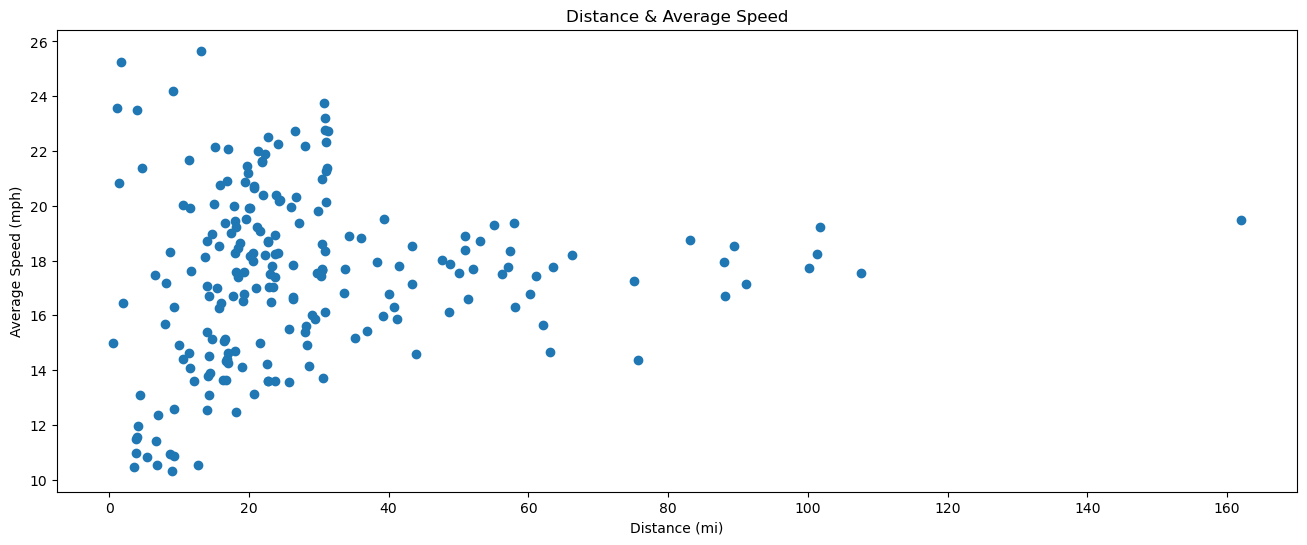

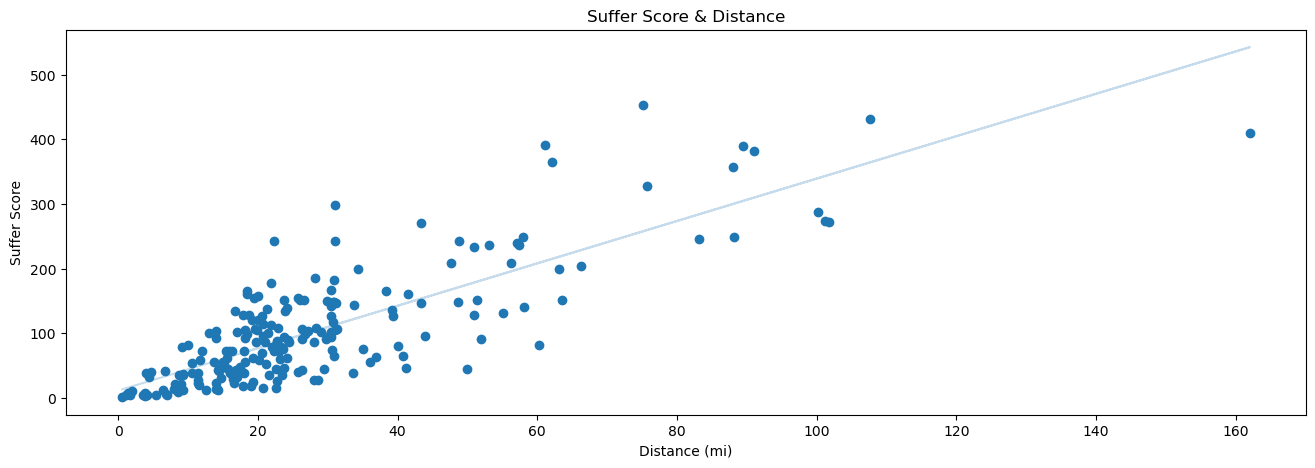

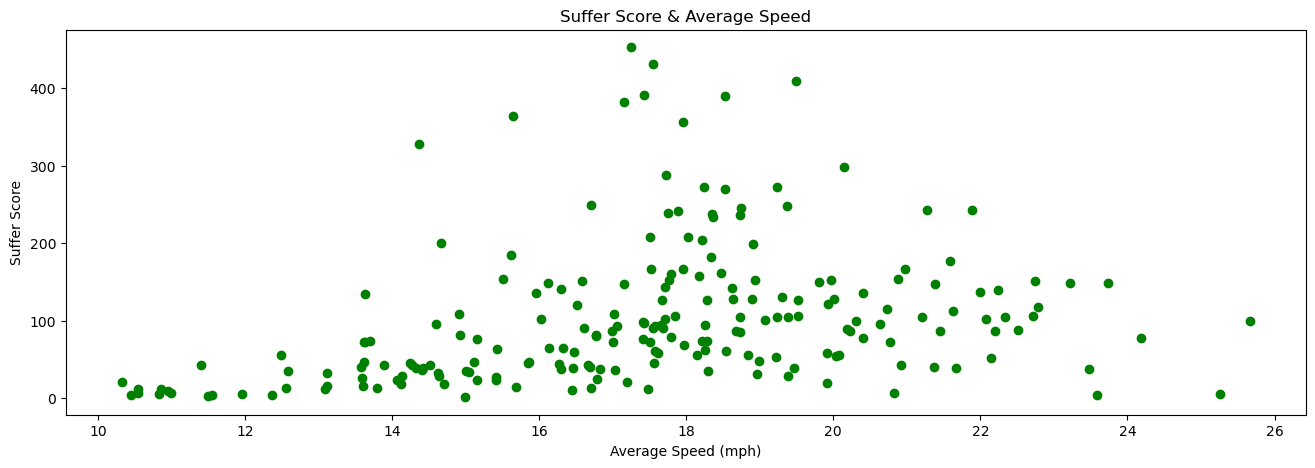

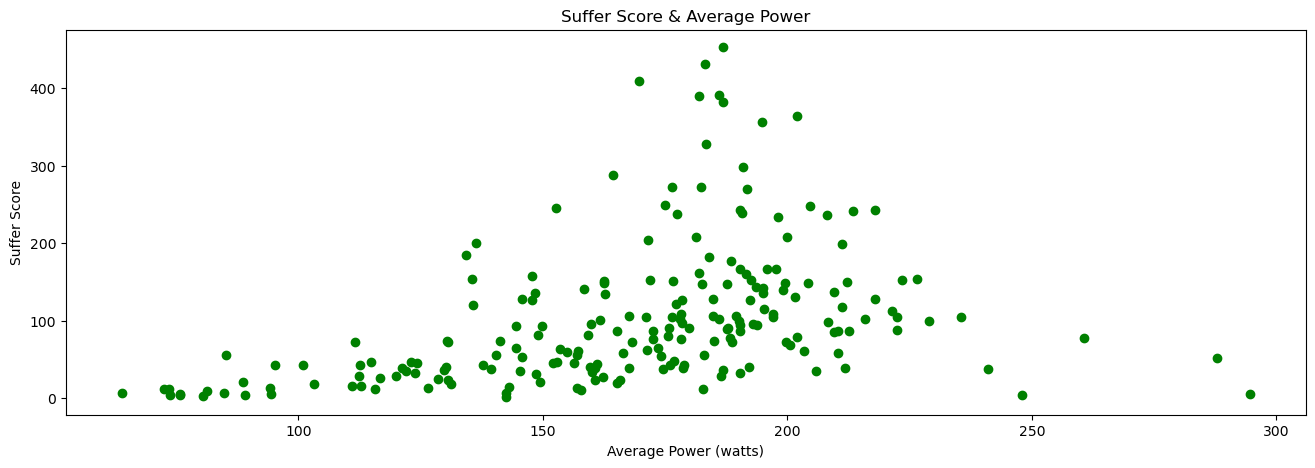

In [23]:
df2 = df[(df['distance']>0) & (df['suffer_score']>0) & (df['average_speed']>10)].copy()

# distance v. speed
plt.figure(figsize=(16, 6))
plt.scatter(df2['distance'], df2['average_speed'])
plt.title('Distance & Average Speed')
plt.xlabel('Distance (mi)')
plt.ylabel('Average Speed (mph)')
plt.show()

# suffer score (a metric Strava creates which is mostly based on heart rate, I believe) v. distance & speed & power
plt.figure(figsize=(16, 5))
x = df2['distance']
y = df2['suffer_score']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, alpha=.25)
plt.title('Suffer Score & Distance')
plt.xlabel('Distance (mi)')
plt.ylabel('Suffer Score')
plt.show()

plt.figure(figsize=(16, 5))
x = df2['average_speed']
y = df2['suffer_score']
plt.scatter(x, y, color='g')
plt.title('Suffer Score & Average Speed')
plt.xlabel('Average Speed (mph)')
plt.ylabel('Suffer Score')
plt.show()

plt.figure(figsize=(16, 5))
x = df2['average_watts']
y = df2['suffer_score']
plt.scatter(x, y, color='g')
plt.title('Suffer Score & Average Power')
plt.xlabel('Average Power (watts)')
plt.ylabel('Suffer Score')
plt.show()

Chart 1 - I have only been able to surpass an averge speed of 20mph on rides shorter than 30 miles.
Chart 2 - Suffer Score appears to be strongly correlated with distance. Note that my longest ride is not my ride with the highest suffer score, though.
Chart 3 - Speed does not seem to have a large effect on suffer score. Probably because my fastest ride are also typically very short and/or indoors (virtual ride).
Chart 4 - Power affects suffer score similarly to speed.

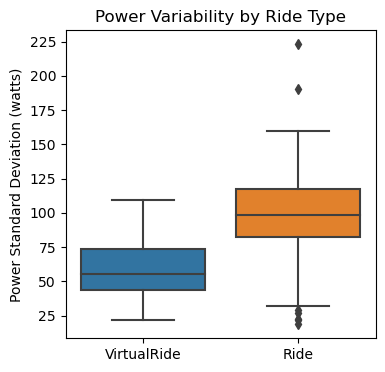

In [24]:
# power variability by ride type
df2 = df[df['power_std']!='n/a'].copy()
plt.figure(figsize=(4, 4))
sns.boxplot(x=df2['type'], y=df2['power_std'])
plt.title('Power Variability by Ride Type')
plt.ylabel('Power Standard Deviation (watts)')
plt.xlabel('')
plt.show()

My outdoor rides have a much more variable power than my indoor rides, likely due to hills/downhills and stoplights.

## Low-Level Analysis

In [25]:
# hardest ride
display(df[['name', 'suffer_score']].loc[df['suffer_score'].idxmax()])

name            Califlorida
suffer_score          453.0
Name: 257, dtype: object

In [26]:
# longest ride
display(df[['name', 'distance']].loc[df['distance'].idxmax()])

name        RAIN 2023 🤩🌧️
distance           161.95
Name: 138, dtype: object

In [27]:
# fastest outdoor ride
df_outdoor = df[df['type']=='Ride'].copy()
display(df_outdoor[['name', 'average_speed']].loc[df_outdoor['average_speed'].idxmax()])

name             Practice Race
average_speed            25.26
Name: 90, dtype: object

In [28]:
# greatest elevation gain
display(df[['name', 'total_elevation_gain']].loc[df['total_elevation_gain'].idxmax()])

name                    Griffy 10k 🚀
total_elevation_gain        10367.45
Name: 182, dtype: object

# Dashboard Setup

In [29]:
import ipywidgets as widgets

# zip ride names with index to use in dropdown
ride_index_zip = tuple([name, index] for name, index in zip(df['name'], df.index))

# list and dicts to assign chart names and colors based on metric dropdown
ride_metrics = ['watts', 'cadence', 'heartrate']
ride_metrics_colors = {'watts': '#4B0082', 'cadence': '#8A0A8A', 'heartrate': 'red'}
ride_metrics_names = {'watts': 'Power', 'cadence': 'Cadence', 'heartrate': 'Heart Rate'}
ride_metrics_units = {'watts': 'watts', 'cadence': 'rpm', 'heartrate': 'bpm'}

# time units
time_units = ['seconds', 'minutes']

# dropdown widget to pick ride from ride name and return its index
ride_picker = widgets.Dropdown(
    placeholder='Choose a Ride',
    options=ride_index_zip,
    description='Ride Name:',
    ensure_option=True,
    disabled=False
)

# dropdown widget to choose a metric for analysis
metric_picker = widgets.Dropdown(
    placeholder='Choose a Metric',
    options=ride_metrics,
    value = 'watts',
    description='Metric:',
    ensure_option=True,
    disabled=False
)

# multi-select widget to choose columns to display
column_picker = widgets.SelectMultiple(
    options=df.columns,
    rows=10,
    value = tuple(['name', 
                   'distance', 
                   'moving_time', 
                   'total_elevation_gain', 
                   'average_speed', 
                   'suffer_score']),
    description='Columns:',
    disabled=False
)


# dropdown widget to choose a units for time of duration slider
time_unit_picker = widgets.Dropdown(
    placeholder='Select Time Unit',
    options=time_units,
    value = 'seconds',
    description='Time Unit:',
    ensure_option=True,
    disabled=False
)

# slider to choose duration for max average power analysis
duration_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=60,
    step=1,
    description='Duration:',
    orientation='horizontal',
    continuous_update=True
)

# normalizes values in 2nd list based on those in 1st (accounts for pauses on rides)
def normalize_metric(time_values, metric_values):
    # create a sequence from min to max of time
    time_norm = list(range(min(time_values), max(time_values) + 1))

    # create an array of zeros with the same length as the normalized time
    metric_norm = [0] * len(time_norm)

    # map the values from the original metric array
    for i, val in enumerate(time_values):
        index = time_norm.index(val)
        if metric_values[i] == None:
            metric_norm[index] = 0
        else:
            metric_norm[index] = metric_values[i]

    return time_norm, metric_norm

# finds the highest x consecutive seconds of the metric in the ride
def find_peak(duration_sec, time_values, metric_values):
    # normalize power values to account for pauses
    time_norm, metric_norm = normalize_metric(time_values, metric_values)
    
    n = len(metric_norm)
    t = duration_sec
    
    # ensure there is enough data
    if n < t:
        return "Not enough data" if n > 0 else None

    # initialize maximum power peak
    max_peak = sum(metric_norm[0:t]) / t

    # iterate over power_norm with window size of duration_sec
    for i in range(n - t + 1):
        # calculate average of the current window
        current_peak = sum(metric_norm[i:i + t]) / t

        # update the maximum average if current is greater
        if current_peak > max_peak:
            max_peak = current_peak

    return max_peak

# function to output selected columns and their values
def return_stats(index, columns):
    col_to_hide = [col for col in df.columns if col not in list(columns)]
    df_skinny = df.drop(col_to_hide, axis=1)
    print(df_skinny.loc[int(index)].to_string())

# converts time in seconds to a datetime time delta (duration)
def time_to_duration(time_list):
    durations = []
    for index, t in enumerate(time_list):
        durations.append(timedelta(seconds = t))
    return durations

# generates x-axis time labels for chart
def generate_time_ticks(time_list):
    interval_duration_sec = max(time_list)/10
    interval_duration = round((interval_duration_sec) / 300) * 300
    if interval_duration == 0:
        interval_duration = 300
    xtick_marks = []
    num_marks = round(max(time_list)/interval_duration)
    for marks in range(0, num_marks):
        xtick_marks.append(interval_duration * marks)
    xtick_marks.append(max(time_list))
    return xtick_marks

# outputs chart based on selected ride and metric    
def return_charts(index, metric): 
    time = df.loc[index]['timeStream']
    time_ticks = generate_time_ticks(time)
    durations = time_to_duration(time_ticks)
    durations_str = list(map(str, durations))
    metric_stream = df.loc[index][f'{metric}Stream']
    if metric_stream == 'n/a':
        print(f'Missing {metric} stream data')
    else:
        plt.figure(figsize=(10, 4))
        sns.lineplot(x=time, y=metric_stream, color=ride_metrics_colors[f'{metric}']);
        plt.title(str(ride_metrics_names[f'{metric}']) + f' - {df["name"].loc[index]}')
        plt.xlabel('Time')
        plt.ylabel(str(ride_metrics_names[f'{metric}']) + ' (' + str(ride_metrics_units[f'{metric}']) + ')')
        plt.xticks(ticks = time_ticks, labels = durations_str, rotation = 75)
        plt.show()

# formatting for displaying the selected metric peak
def return_peak(index, metric, duration, unit):
    metric_stream = df[f'{metric}Stream'].loc[index]
    time_stream = df['timeStream'].loc[index]
    try:
        if unit == 'seconds':
            print('Max average power for selected duration: ' + "\033[1m" + str(round(find_peak(duration, time_stream, metric_stream))) + ' ' + str(ride_metrics_units[f'{metric}']))
        elif unit == 'minutes':
            print('Max average power for selected duration: ' + "\033[1m" + str(round(find_peak(duration*60, time_stream, metric_stream))) + ' ' + str(ride_metrics_units[f'{metric}']))
    except TypeError:
        print('Choose a shorter duration')
    except IndexError:
        print(f'Missing {metric} stream data')

'''
def return_map(index): 
    if df.loc[index]['map_polyline'] == '':
        print('Missing map data for this ride')
    else:
        # decode polyline
        polyline_str = df.loc[index]['map_polyline']
        decoded_points = polyline.decode(polyline_str)
        
        # create map, add the polyline to the map
        mymap = folium.Map()
        folium.PolyLine(decoded_points).add_to(mymap)

        # fit map to route
        bounds = decoded_points
        mymap.fit_bounds(bounds)
        display(mymap)
'''

# comparisnon of this ride's average x metric to the overall average of the dataset
def return_charts2(index, metric): 
    try:
        total_avg_metric = df[f'average_{metric}'].mean()
        avg_metric = sum(df.loc[index][f'{metric}Stream'])/len(df.loc[index][f'{metric}Stream'])
        if avg_metric >= total_avg_metric:
            this_ride_color = 'green'
        else:
            this_ride_color = 'red'

        values = [total_avg_metric, avg_metric]
        labels = [f'All-Time Average {metric}', f'This Ride\'s Average {metric}']
        plt.figure(figsize=(6, 3))
        bars = plt.bar(labels, values, color=[ride_metrics_colors[metric], this_ride_color])
        plt.ylabel(str(ride_metrics_names[f'{metric}']) + ' (' + str(ride_metrics_units[f'{metric}']) + ')')
        
        for bar in bars:
            yval = bar.get_height() - 20
            plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

        plt.show()
    except TypeError:
        print(f'Missing {metric} stream data')
        
def return_charts3(index):
    try:
        previous_indexes = range(10, -1, -1)
        values = []
        labels = []
        for i in previous_indexes:
            values.append(df.loc[index - i]['suffer_score'])
            labels.append(str(i))
        labels[len(labels) - 1] = 'This Ride'
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=labels, y=values, color='red')
        plt.xticks(ticks=labels, labels=labels)
        plt.title('Suffer Score Trend')
        plt.xlabel('Previous 10 Rides')
        plt.ylabel('Suffer Score')
        plt.show()
    except KeyError:
        print('Missing suffer score data')

# widget sizes
ride_picker.layout.width = '400px'
ride_picker.layout.height = '30px'
duration_slider.layout.width = '750px'
duration_slider.layout.height = '30px'
divider = widgets.HTML('<hr>')

# create interactive outputs for widgets
out = widgets.interactive_output(return_stats, {'index': ride_picker, 'columns':column_picker})
out_charts = widgets.interactive_output(return_charts, {'index': ride_picker, 'metric': metric_picker})
out_charts2 = widgets.interactive_output(return_charts2, {'index': ride_picker, 'metric': metric_picker})
out_charts3 = widgets.interactive_output(return_charts3, {'index': ride_picker})
out_peaks = widgets.interactive_output(return_peak, {'index': ride_picker, 'duration': duration_slider, 'unit': time_unit_picker, 'metric': metric_picker})
#out_map = widgets.interactive_output(return_map, {'index': ride_picker})

# Dashboard

In [30]:
display(widgets.HBox([
    widgets.VBox([ride_picker, 
                  column_picker,
                  out,
                  divider,
                  #out_map,
                  divider,
                  out_charts3]),
    widgets.VBox([metric_picker,
                  out_charts,
                  out_charts2,
                  divider,
                  time_unit_picker,
                  duration_slider,
                  out_peaks,
                  divider
                  ])
]))